In [7]:
import numpy as np
import os
import onnxruntime as ort
import tqdm
import cv2
import matplotlib.pyplot as plt

model_path = '../xfeat_matching.onnx'    # python ./export.py --dynamic --export_path ./xfeat_matching.onnx

#Load some example images
im1 = cv2.imread('../assets/ref.png', cv2.IMREAD_COLOR)
im2 = cv2.imread('../assets/tgt.png', cv2.IMREAD_COLOR)

## Simple function that fits an homography in a set of matches and draw the homography transform

In [8]:
def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

In [9]:
tmp_ort_session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])

# print the input,output names and shapes
for i in range(len(tmp_ort_session.get_inputs())):
    print(f"Input name: {tmp_ort_session.get_inputs()[i].name}, shape: {tmp_ort_session.get_inputs()[i].shape}")
for i in range(len(tmp_ort_session.get_outputs())):
    print(f"Output name: {tmp_ort_session.get_outputs()[i].name}, shape: {tmp_ort_session.get_outputs()[i].shape}")


providers = [
    # The TensorrtExecutionProvider is the fastest.
    ('TensorrtExecutionProvider', { 
        'device_id': 0,
        'trt_max_workspace_size': 4 * 1024 * 1024 * 1024,
        'trt_fp16_enable': True,
        'trt_engine_cache_enable': True,
        'trt_engine_cache_path': './trt_engine_cache',
        'trt_engine_cache_prefix': 'model',
        'trt_dump_subgraphs': False,
        'trt_timing_cache_enable': True,
        'trt_timing_cache_path': './trt_engine_cache',
        #'trt_builder_optimization_level': 3,
    }),

    # The CUDAExecutionProvider is slower than PyTorch, 
    # possibly due to performance issues with large matrix multiplication "cossim = torch.bmm(feats1, feats2.permute(0,2,1))"
    # Reducing the top_k value when exporting to ONNX can decrease the matrix size.
    ('CUDAExecutionProvider', { 
        'device_id': 0,
        'gpu_mem_limit': 4 * 1024 * 1024 * 1024,
    }),
    ('CPUExecutionProvider',{ 
    })
]
ort_session = ort.InferenceSession(model_path, providers=providers)

Input name: images0, shape: ['batch', 3, 'height', 'width']
Input name: images1, shape: ['batch', 3, 'height', 'width']
Output name: matches, shape: ['Concatmatches_dim_0', 4]
Output name: batch_indexes, shape: ['GatherNDbatch_indexes_dim_0']


/opt/anaconda3/envs/xfeat/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'TensorrtExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
/opt/anaconda3/envs/xfeat/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


## Prepare the input tensor

In [16]:
# im1 = cv2.resize(im1, dsize=None, fx=0.8, fy=0.8, interpolation=cv2.INTER_LINEAR)
# im2 = cv2.resize(im2, dsize=None, fx=0.8, fy=0.8, interpolation=cv2.INTER_LINEAR)

input_array_1 = im1.transpose(2, 0, 1).astype(np.float32)
input_array_1 = np.expand_dims(input_array_1, axis=0)
input_array_2 = im2.transpose(2, 0, 1).astype(np.float32)
input_array_2 = np.expand_dims(input_array_2, axis=0)

batch_size = 1

# Psuedo-batch the input images
input_array_1 = np.concatenate([input_array_1 for _ in range(batch_size)], axis=0)
input_array_2 = np.concatenate([input_array_2 for _ in range(batch_size)], axis=0)

inputs = {
    ort_session.get_inputs()[0].name: input_array_1,
    ort_session.get_inputs()[1].name: input_array_2
}

## Run matching

In [17]:
outputs = ort_session.run(None, inputs)

In [18]:
# Validate the outputs of the psuedo-batched inputs
matches = outputs[0]
batch_indexes = outputs[1]

matches_0 = matches[batch_indexes == 0]
valid = []
for i in range(1, input_array_1.shape[0]):
    valid.append(np.all(matches_0 == matches[batch_indexes == i]))
print(f"equal: {valid}")

equal: []


In [19]:
import time

# Run the model 100 times to get an average time
times = []
for i in tqdm.tqdm(range(100)):
    start = time.time()
    outputs = ort_session.run(None, inputs)
    times.append(time.time() - start)

print(f"Average time per batch: {np.mean(times):.4f} seconds")
print(f"Average time per image: {np.mean(times)/batch_size:.4f} seconds")
print(f"Average FPS per image: {batch_size/np.mean(times):.4f}")

100%|██████████| 100/100 [00:16<00:00,  5.90it/s]

Average time per batch: 0.1689 seconds
Average time per image: 0.1689 seconds
Average FPS per image: 5.9222


## Draw the matches

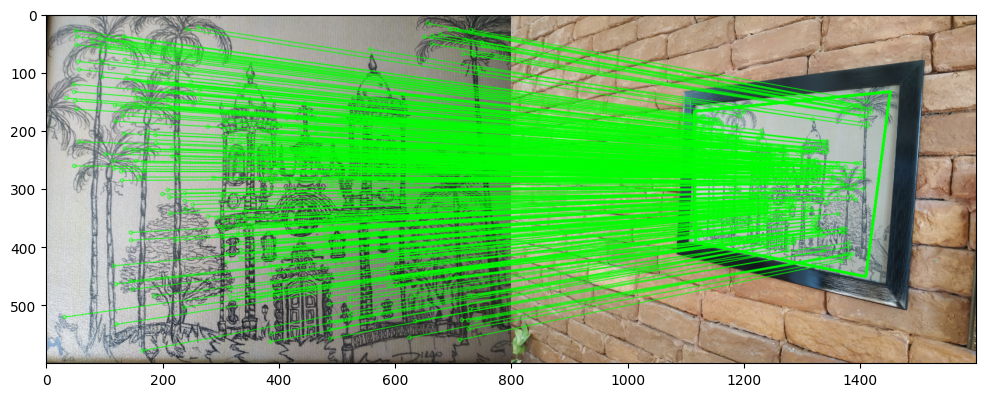

In [20]:
matches = outputs[0]
batch_indexes = outputs[1]
mkpts_0, mkpts_1 = matches[batch_indexes == 0][..., :2], matches[batch_indexes == 0][..., 2:]

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1])
plt.show()